In [ ]:
import sys
sys.path.append('../src')
import torch
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    DDIMScheduler,
    AutoencoderKL,
)
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

from ip_adapter import IPAdapter

In [2]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "models/image_encoder/"
# ckpt = r"contours-masks\\checkpoint-4000\\pytorch_model.bin"
ckpt = None
ip_ckpt = "ip_adapter.bin"
device = "cuda"

In [3]:
if ckpt:
    sd = torch.load(ckpt, map_location="cpu")
    image_proj_sd = {}
    ip_sd = {}
    for k in sd:
        if k.startswith("unet"):
            pass
        elif k.startswith("image_proj_model"):
            image_proj_sd[k.replace("image_proj_model.", "")] = sd[k]
        elif k.startswith("adapter_modules"):
            ip_sd[k.replace("adapter_modules.", "")] = sd[k]

    torch.save({"image_proj": image_proj_sd, "ip_adapter": ip_sd}, ip_ckpt)

In [27]:
def image_blend_grid(ref, imgs, rows, cols, alpha=0.6):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(
            Image.blend(img, ref, alpha),
            box=(i%cols*w, i//cols*h)
            )
    return grid

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img,
            box=(i%cols*w, i//cols*h)
            )
    return grid

vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [42]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00095,
    beta_end=0.016,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)


In [6]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:09<00:00,  1.89s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


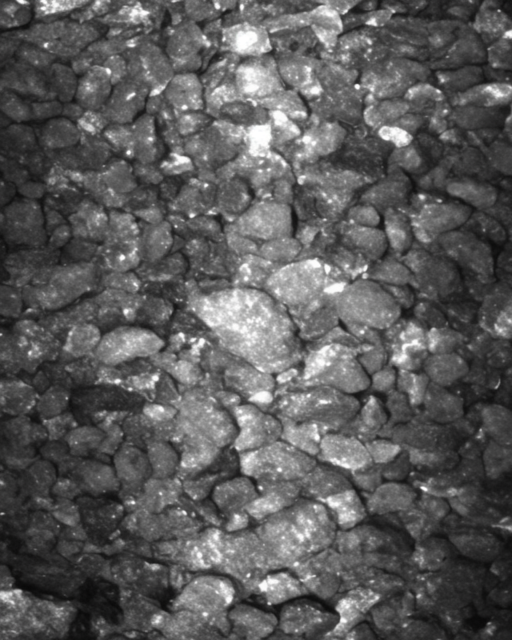

In [ ]:
# read image prompt
image = Image.open(r"")
height = 512
width = int(800 / 640 * height)
image = image.resize((height, width))
image2 = ImageOps.equalize(image)
image

In [8]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

d:\vscode\ctci\IP-Adapter\ip_adapter\ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


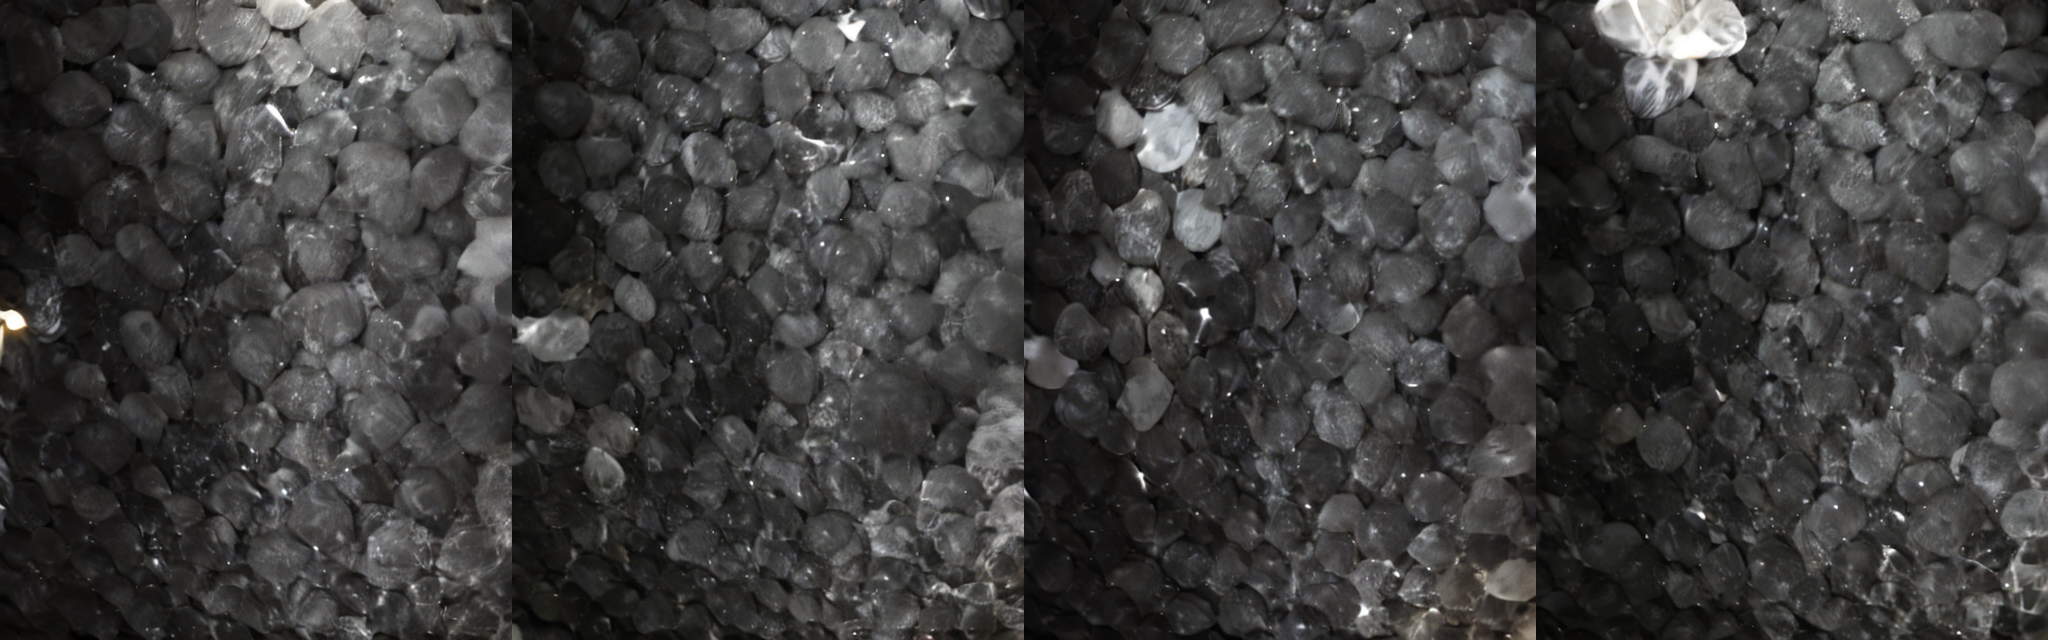

In [9]:
# generate image variations
images = ip_model.generate(
    pil_image=image2,
    num_samples=4,
    num_inference_steps=50,
    scale=1,
    seed=42,
    # negative_prompt="best quality regular shapes even surface round metallicslippery polished smooth",
    # prompt="conveyer belt monochrome, worst quality, poor lightning, rough porous angular rocks",
    negative_prompt="randmom black spots. many details. lines. drawing. misplaced.low-contrast, colorful.",
    prompt="a segmentation mask. one mask for the rock. no details. precise. black and white. each mask covers the one rock and separates from the others.",
    width=image.size[0],
    height=image.size[1],
    guidance_scale=10
    )
grid = image_grid(images, 1, 4)
grid

## Image-to-Image

In [43]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...: 100%|██████████| 5/5 [00:06<00:00,  1.30s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


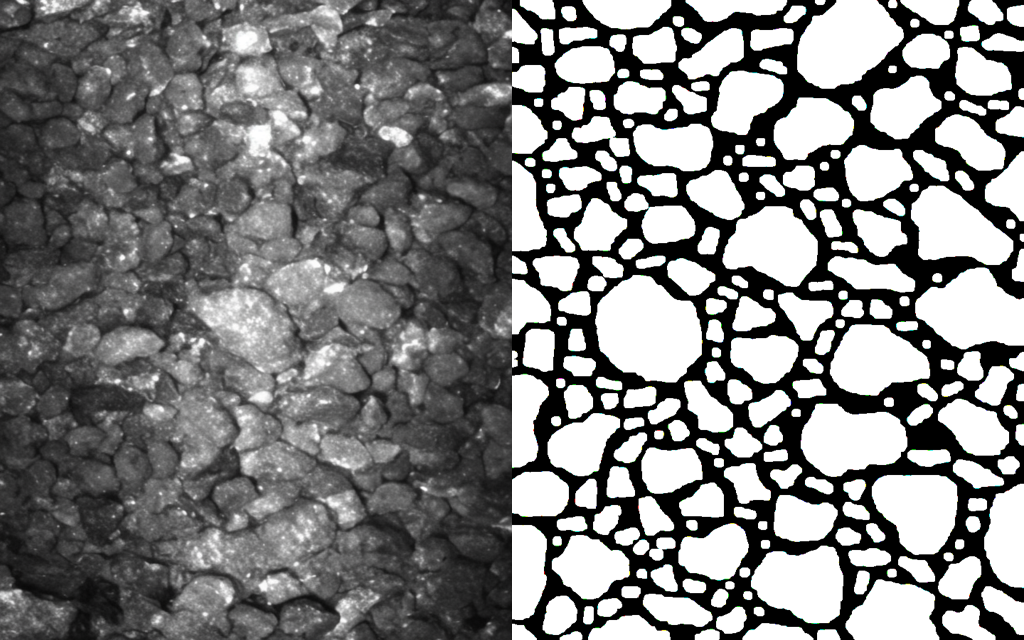

In [ ]:
# # read image prompt
g_image = Image.open(r"data\generated_masks\0.png")
g_image = g_image.convert('RGB')
image_grid([image.resize((height, width)), g_image.resize((height, width))], 1, 2)

In [45]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

d:\vscode\ctci\IP-Adapter\ip_adapter\ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")


c:\Users\dasha\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion_img2img.py:768: FutureWarning: You have passed 4 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


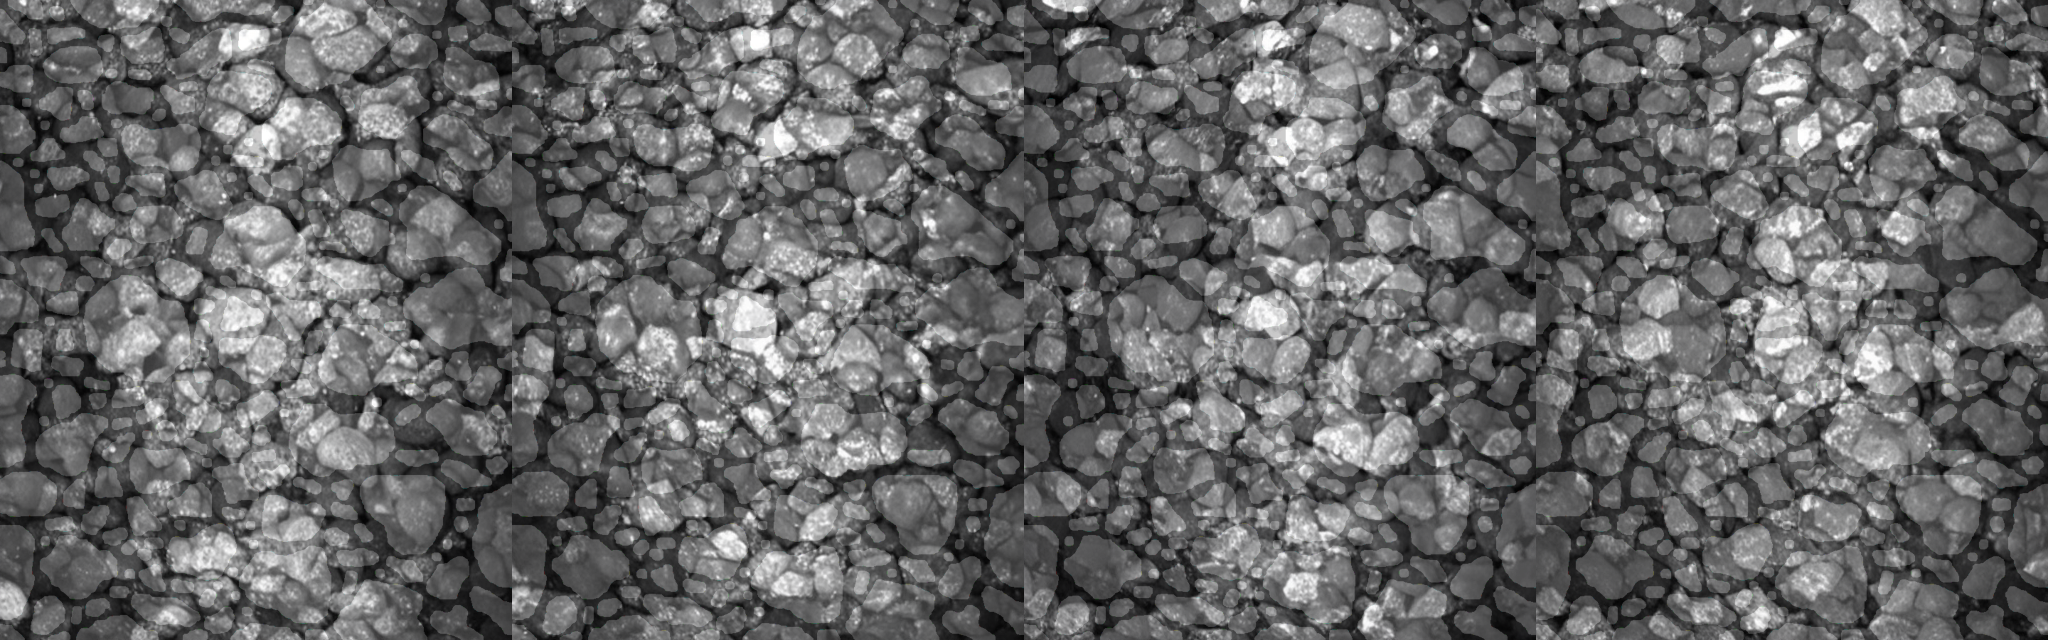

In [47]:
# generate
images = ip_model.generate(
    pil_image=g_image,
    num_samples=4,
    num_inference_steps=50,
    scale=0.9,
    seed=42,
    image=image,
    strength=0.5,
    guidance_scale=3,
    negative_prompt="best quality regular shapes even surface round metallicslippery polished smooth",
    prompt="conveyer belt monochrome, worst quality, poor lightning, rough porous angular rocks",
    )
g_image = g_image.resize(images[0].size)
grid = image_blend_grid(g_image, images, 1, 4, alpha=0.2)
grid